In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import shap
import pickl


In [2]:
df_mat = pd.read_csv("student-mat.csv", sep=";")
df_por = pd.read_csv("student-por.csv", sep=";")

merge_cols = [
    'school', 'sex', 'age', 'address', 'famsize', 'Pstatus',
    'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'nursery', 'internet'
]

# Merge on common columns, only keep exact matches
merged = pd.merge(df_mat, df_por, on=merge_cols, suffixes=('_mat', '_por'))


In [3]:
df = merged.copy()

# Drop the Portuguese grade columns (optional)
drop_cols = ['G1_por', 'G2_por', 'G3_por']
df = df.drop(columns=drop_cols)

# Set target
target = 'G3_mat'

# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Split features and labels
X = df.drop(columns=[target])
y = df[target]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [5]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best MSE (CV): {-grid_search.best_score_:.2f}")

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50, 'subsample': 0.8}
Best MSE (CV): 3.00


In [6]:
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(f"Test MSE: {mse:.2f}")

Test MSE: 2.00


In [7]:
with open('xgb_student_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

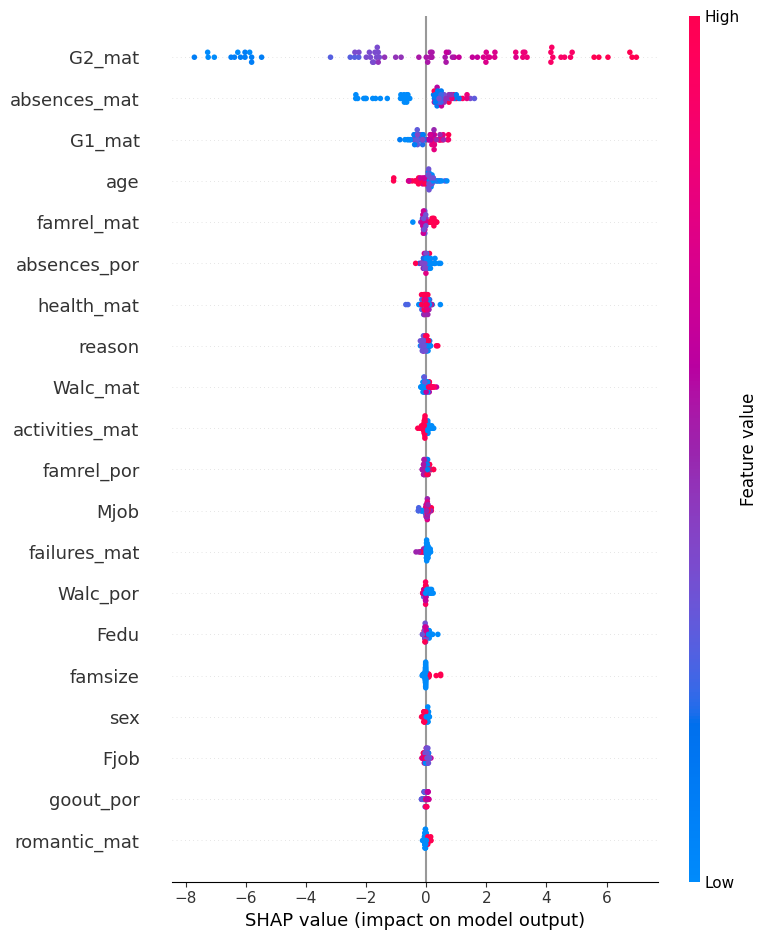

In [8]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)